# Download data to Colab

This notebook shows how to download the hackathon data to the Colab drive.


In [0]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# wrapper to cut & paste "shareable link"
def download_drive_file(file_share_link):
  file_id = file_share_link[file_share_link.find("=") + 1:]
  file = drive.CreateFile({'id': file_id }) #DRIVE_FILE_ID is file id example: 1iytA1n2z4go3uVCwE_vIKouTKyIDjEq
  fname = file['title']
  if not os.path.exists(fname):
    file.GetContentFile(fname)  # Save Drive file as a local file

In [0]:
!ls -l

total 6398364
-rw-r--r-- 1 root root       2620 Nov 15 02:52 adc.json
drwxr-xr-x 1 root root       4096 Nov  6 16:17 sample_data
-rw-r--r-- 1 root root  101477907 Nov 15 02:54 train_gold.tsv
-rw-r--r-- 1 root root 6450432334 Nov 15 03:30 train.h5


In [0]:
# download the data
download_drive_file("https://drive.google.com/open?id=15D6EmC3XTPhPERfR8I6nfy-4dbZiKW_z") # training set
download_drive_file("https://drive.google.com/open?id=1IoZiRUvH3eu5SymQYG6MfhzIwxEMZFYg") # training gold
!ls -l

total 6398364
-rw-r--r-- 1 root root       2620 Nov 15 02:52 adc.json
drwxr-xr-x 1 root root       4096 Nov  6 16:17 sample_data
-rw-r--r-- 1 root root  101477907 Nov 15 02:54 train_gold.tsv
-rw-r--r-- 1 root root 6450432334 Nov 15 03:30 train.h5


In [0]:
import h5py
from pandas import read_csv
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

labels = read_csv('train_gold.tsv', delimiter='\t', index_col=0, names=['reference'])

print(labels.head(5))

with h5py.File('train.h5') as f:
  assert(labels.shape[0] == f['id'].shape[0])
  assert(labels.shape[0] == f['img'].shape[0])
  assert(labels.shape[0] == f['shape'].shape[0])
  assert(labels.index.isin(np.asarray(f['id'])).all())
  
print('Dataset info is OK')


        reference
1655573  posible,
1655574      Jose
1655575        de
1655576   OFICINA
1655577        Gu
Dataset info is OK


In [0]:
f = h5py.File('./train.h5')

def show_image(i):
  ids = f['id']
  imgs = f['img']
  shapes = f['shape']
  shape = shapes[i]
  block_len = int(shape[0]) * int(shape[1])  # number of pixels
  block_bits = imgs[i]            # get packed bits
  block_pixels = np.unpackbits(block_bits)         # unpack bits into boolean pixels
  block_pixels = block_pixels[:block_len]          # discard trailing bits generate during packing
  block_array = np.reshape(block_pixels, shape)
  plt.imshow(block_array)
  plt.title('id: {}, target: {}'.format(ids[i], labels.reference.values[i]))
  plt.show()
  return

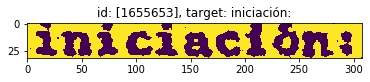

In [0]:
show_image(56)

In [0]:
"""
with h5py.File('./train.h5') as f:
    ids = f['id']
    imgs = f['img']
    shapes = f['shape']
    for i in range(ids.shape[0])[:10]:
        shape = shapes[i]
        block_len = int(shape[0]) * int(shape[1])  # number of pixels
        block_bits = imgs[i]            # get packed bits
        block_pixels = np.unpackbits(block_bits)         # unpack bits into boolean pixels
        block_pixels = block_pixels[:block_len]          # discard trailing bits generate during packing
        block_array = np.reshape(block_pixels, shape)
        plt.imshow(block_array)
        plt.title('id: {}, target: {}'.format(ids[i], labels.reference.values[i]))
        plt.show()
"""

"\nwith h5py.File('./train.h5') as f:\n    ids = f['id']\n    imgs = f['img']\n    shapes = f['shape']\n    for i in range(ids.shape[0])[:10]:\n        shape = shapes[i]\n        block_len = int(shape[0]) * int(shape[1])  # number of pixels\n        block_bits = imgs[i]            # get packed bits\n        block_pixels = np.unpackbits(block_bits)         # unpack bits into boolean pixels\n        block_pixels = block_pixels[:block_len]          # discard trailing bits generate during packing\n        block_array = np.reshape(block_pixels, shape)\n        plt.imshow(block_array)\n        plt.title('id: {}, target: {}'.format(ids[i], labels.reference.values[i]))\n        plt.show()\n"

In [0]:
labels

,reference
1655573,"posible,"
1655574,Jose
1655575,de
1655576,OFICINA
1655577,Gu
...,...
11589005,nacionalidad
11589006,que
11589008,de
11589009,"consecuencia, como"


In [0]:
# Determine unique labels + eos
long_string = ""
for i in tqdm(labels.reference.values):
  long_string += i
long_string = list(long_string)
long_string.insert(0, "<eos>")
long_string.insert(0, "<sos>")
long_string.insert(0, "<pad>")
my_labels, counts = np.unique(long_string, return_counts=True)

100%|██████████| 6953406/6953406 [00:02<00:00, 2648328.94it/s]


In [0]:
# Encoder
char2idx = {u:i for i, u in enumerate(my_labels)}
idx2char = np.array(my_labels)

In [0]:
# Add eos and sos to labels datframe
encoded_labels = []
seq_len = []
for lab in tqdm(labels.reference.values):
  encoded = [char2idx[i] for i in list(lab)]
  seq_len.append(len(encoded))
  encoded.append(char2idx["<eos>"])
  encoded.insert(0, char2idx["<sos>"])
  encoded_labels.append(encoded)
labels["seq_len"] = seq_len
labels["encoded_labels"] = encoded_labels

100%|██████████| 6953406/6953406 [00:22<00:00, 314554.15it/s]


In [0]:
labels.head

<bound method NDFrame.head of                    reference  ...                                     encoded_labels
1655573             posible,  ...           [29, 77, 76, 80, 70, 63, 73, 66, 10, 27]
1655574                 Jose  ...                           [29, 42, 76, 80, 66, 27]
1655575                   de  ...                                   [29, 65, 66, 27]
1655576              OFICINA  ...               [29, 47, 38, 41, 35, 41, 46, 33, 27]
1655577                   Gu  ...                                   [29, 39, 82, 27]
...                      ...  ...                                                ...
11589005        nacionalidad  ...  [29, 75, 62, 64, 70, 76, 75, 62, 73, 70, 65, 6...
11589006                 que  ...                               [29, 78, 82, 66, 27]
11589008                  de  ...                                   [29, 65, 66, 27]
11589009  consecuencia, como  ...  [29, 64, 76, 75, 80, 66, 64, 82, 66, 75, 64, 7...
11589010                 vez  ...  

In [0]:
import torch
from scipy import stats

In [0]:
class Flatten(torch.nn.Module):
    def forward(self, input):
        return input.reshape(input.size(0), -1)

In [0]:
class GRU(torch.nn.Module):
  def __init__(self, nin, nh, nlayers=1, ks=3, nf=2, do=0.5):
    super(GRU, self).__init__()
    self.nh = nh
    self.ks = ks
    self.relu = torch.nn.ReLU()
    self.nf = nf
    if nlayers >= 2:
        self.rnn = torch.nn.GRU(input_size=nin, hidden_size=nh, num_layers=nlayers, dropout=do, batch_first=True)
    else:
        self.rnn = torch.nn.GRU(input_size=nin, hidden_size=nh, num_layers=nlayers, batch_first=True)
    # Convolutional layers
    self.conv1 = torch.nn.Conv2d(1, self.nf, kernel_size=3, padding=int(ks / 2))
    self.maxpool1 = torch.nn.MaxPool2d(kernel_size=2)
    self.bn1 = torch.nn.BatchNorm2d(self.nf)
    self.conv2 = torch.nn.Conv2d(self.nf, 2 * self.nf, kernel_size=3, padding=int(ks / 2))
    self.maxpool2 = torch.nn.MaxPool2d(kernel_size=2)
    self.bn2 = torch.nn.BatchNorm2d(2 * self.nf)
    self.flatten = Flatten()

    def convolutions(self, x):
      x = self.maxpool1(self.relu(self.bn1(self.conv1(x))))
      x = self.maxpool2(self.relu(self.bn2(self.conv2(x))))
      return self.flatten(x)

    def forward(self, img, text):
      f = self.convolutions(img)
      y_pred = self.recurrence(f, text)
      return y_pred

    def recurrence(self, x, hidden):
      output, hidden = self.rnn(x, hidden)
      return output

        

In [0]:
class Label2OneHot(object):
    def __init__(self, nlabels):
        self.nlabels = nlabels

    def __call__(self, x):
        return torch.nn.functional.one_hot(x.long(), num_classes=self.nlabels).float()

In [0]:
gru = GRU(nin=5,
          nh=32,
          nlayers=1,
          ks=3,
          nf=2,
          do=0.5
          )

In [0]:
label2onehot = Label2OneHot(len(my_labels))

In [0]:
imgs = f['img']
shapes = f['shape']

In [0]:
mask1 = shapes[:, 0] <= 36
mask2 = shapes[:, 1] <= 72
mask = mask1 * mask2

In [0]:
index = np.arange(len(labels))[mask]
new_images_array = np.zeros((np.sum(mask), 36, 72), dtype=np.uint8)
for i, idx in tqdm(enumerate(index)):
  shape = shapes[idx]
  block_len = int(shape[0]) * int(shape[1])  # number of pixels
  block_bits = imgs[idx]            # get packed bits
  block_pixels = np.unpackbits(block_bits)         # unpack bits into boolean pixels
  block_pixels = block_pixels[:block_len]          # discard trailing bits generate during packing
  block_array = np.reshape(block_pixels, shape)
  new_images_array[i, :shape[0], :shape[1]] = np.logical_not(block_array)

779088it [02:59, 4340.40it/s]


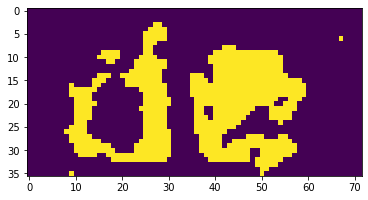

In [0]:
plt.imshow(new_images_array[-1])

In [0]:
new_reference = labels.reference.values[mask]
new_encoded_values = labels.encoded_labels.values[mask]
new_seq_len = labels.seq_len.values[mask]

In [0]:
y = np.zeros((np.sum(mask), np.max(new_seq_len) + 2), dtype=int)
for i, value in tqdm(enumerate(new_encoded_values)):
  y[i, :new_seq_len[i] + 2] = value
print(y)


779088it [00:01, 581390.48it/s]

[[29 65 66 ...  0  0  0]
 [29 39 82 ...  0  0  0]
 [29 66 46 ...  0  0  0]
 ...
 [29 65 66 ...  0  0  0]
 [29 38 47 ...  0  0  0]
 [29 65 66 ...  0  0  0]]


In [0]:
x_sample = torch.tensor(new_images_array[:10], dtype=torch.float32).unsqueeze(1)
y_sample = torch.tensor(y[:10], dtype=torch.long)
one_hot_text = label2onehot(y_sample)
print(x_sample.shape)
print(y_sample.shape)

torch.Size([10, 1, 36, 72])
torch.Size([10, 10])


In [0]:
new_encoded_values

array(['de', 'Gu', 'eN', ..., 'de', 'FO', 'de'], dtype=object)

In [0]:
gru(x_sample, one_hot_text)

NotImplementedError: ignored

In [0]:
one_hot_text.shape

torch.Size([10, 10, 110])